In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.utils import _hpid2RaDec

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
# Get rid of the silly north stripe
def standard_goals(nside=None):
    """
    A quick function to generate the "standard" goal maps.
    """
    # Find the number of healpixels we expect to observe per observation
    if nside is None:
        nside = fs.set_default_nside()

    result = {}
    result['u'] = fs.generate_goal_map(nside=nside, NES_fraction=0.,
                                    WFD_fraction=0.31, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['g'] = fs.generate_goal_map(nside=nside, NES_fraction=0.2,
                                    WFD_fraction=0.44, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['r'] = fs.generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['i'] = fs.generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['z'] = fs.generate_goal_map(nside=nside, NES_fraction=0.4,
                                    WFD_fraction=0.9, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['y'] = fs.generate_goal_map(nside=nside, NES_fraction=0.,
                                       WFD_fraction=0.9, SCP_fraction=0.15,
                                       GP_fraction=0.15,
                                       WFD_upper_edge_fraction=0.)

    return result

In [3]:
nside = fs.set_default_nside(nside=32)


# Let's set up some alt_az maps
alt_az_blockmaps = []
# Bump up nside to make interpolation work
hpids = np.arange(hp.nside2npix(nside*2))
az, alt = _hpid2RaDec(nside*2, hpids)

alt_low_limit = np.radians(20.)
alt_high_limit = np.radians(82.)
az_half_width = np.radians(15.)

blank_map = hpids *0.
good = np.where( ((az > 2.*np.pi-az_half_width) | (az < az_half_width)) &
                (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)

good = np.where(((az > np.pi-az_half_width) & (az < np.pi+az_half_width)) &
                (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)

# let's expand this one a bit
good = np.where((az > np.pi/2 - az_half_width*2) & (az < np.pi/2+az_half_width*2) & 
               (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)


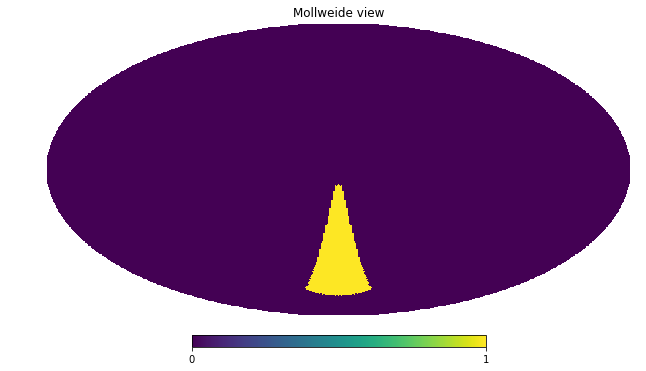

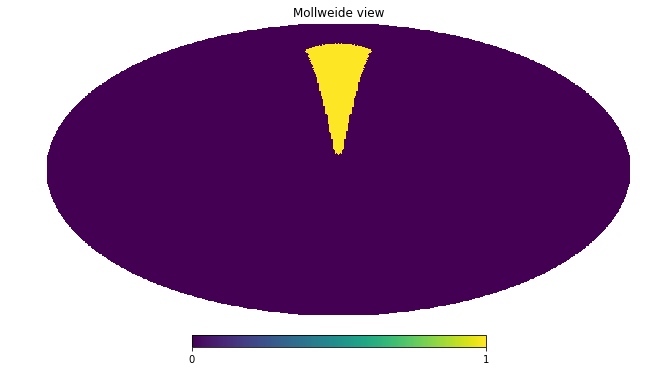

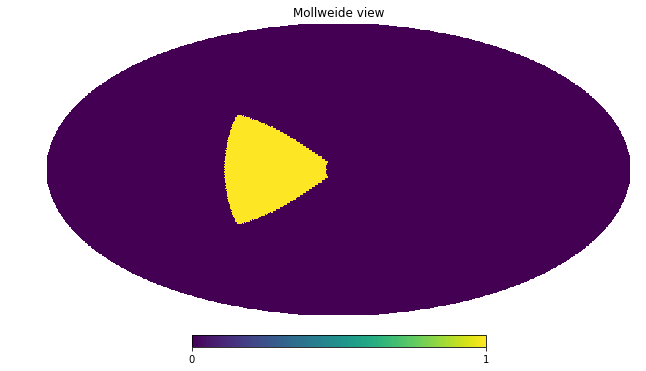

In [4]:
# Let's see what my masks look like
for aamap in alt_az_blockmaps:
    hp.mollview(aamap, rot=(0,90))

In [5]:
survey_length = 366 #365.25*10  # days

# Define what we want the final visit ratio map to look like
years = np.round(survey_length/365.25)
# get rid of silly northern strip.
target_map = standard_goals(nside=nside)

#filters = ['u', 'g', 'r', 'i', 'z', 'y']

surveys = []

# To really get going, could use m5 and target map of multiple filters. Then 
# it'll pick the block scheduler that is best for both filters.

filtername = 'r'
bfs = []
bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                        target_map=target_map[filtername],
                                        out_of_bounds_val=hp.UNSEEN, nside=nside))
bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
# I think this will help make patches more clumpy
bfs.append(fs.Constant_basis_function())
# XXX--put a huge boost on staying in the filter. Until I can tier surveys as list-of-lists
weights = np.array([3.0, 0.3, 3., 50.])
# Let's do g and r in pairs. 
# XXX-When expanding to more block_surveys, could use basis functions in each of the filters
# This is where we could add a look-ahead basis function to include m5_diff in the future.
# Actually, having a near-future m5 would also help prevent switching to u or g right at twilight.
# Maybe just need a "filter future" basis function? 
surveys.append(fs.Block_survey(bfs, weights, filtername='r', filter2='g',
                               dither=True, nside=nside, ignore_obs='DD',
                               alt_az_masks=alt_az_blockmaps))
    
# Let's set up some standard surveys as well to fill in the gaps 
# (leaving off r and g just to make viz simple)
filters = ['i', 'z', 'y']
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside))

    bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
    #bfs.append(fs.Zenith_mask_basis_function(maxAlt=78., penalty=-100, nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))

    weights = np.array([6.0, 0.3, 1., 3., 3.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                           dither=True, nside=nside, ignore_obs='DD'))

# Set up the DD
#dd_surveys = fs.generate_dd_surveys()
#surveys.extend(dd_surveys)


In [6]:
n_visit_limit = None
scheduler = fs.Core_scheduler(surveys, nside=nside)
observatory = Speed_observatory(nside=nside, quickTest=True)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='block_test%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)

/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 2.3%

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:313: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:229: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


progress = 100.0%Skipped 0 observations
Completed 201449 observations


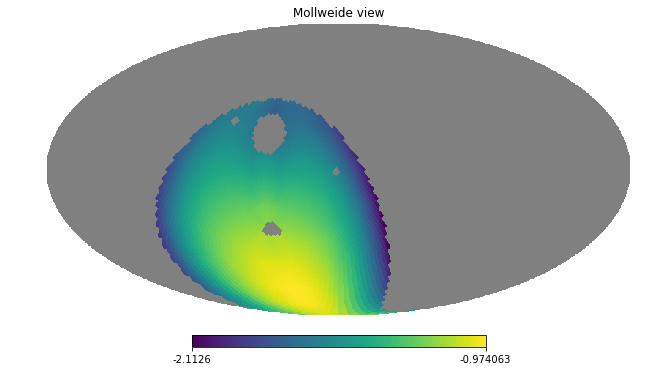

In [7]:
hp.mollview(scheduler.surveys[0].basis_functions[0]())

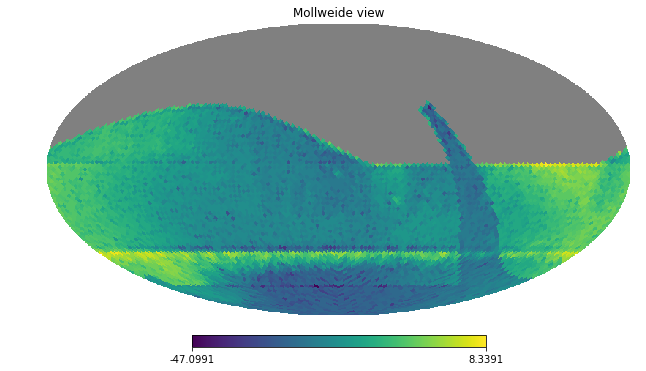

In [8]:
hp.mollview(scheduler.surveys[0].basis_functions[1]())

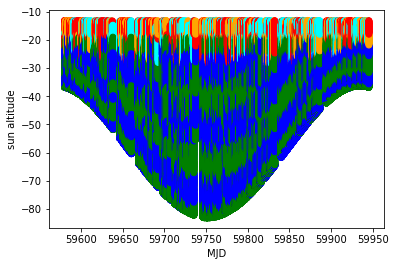

In [9]:
# The poor man's hourglass plot.
filter2color = {'u': 'purple', 'g': 'blue', 'r': 'green',
                             'i': 'cyan', 'z': 'orange', 'y': 'red'}
color_convert = [filter2color[filtername] for filtername in observations['filter']]
plt.scatter(observations['mjd'], observations['sunAlt'], c=color_convert)
plt.xlabel('MJD')
plt.ylabel('sun altitude')
#plt.xlim([observations['mjd'].min()+1, observations['mjd'].min()+5.4])
#plt.xlim([59695, 59710])

In [10]:
np.where((observations['sunAlt'] > -19.) &(observations['filter'] == 'u'))

(array([], dtype=int64),)

In [11]:
reward = surveys[0].calc_reward_function()
if np.size(reward) > 1:
    hp.mollview(reward, title='block reward, max=%.2f' % reward.max())

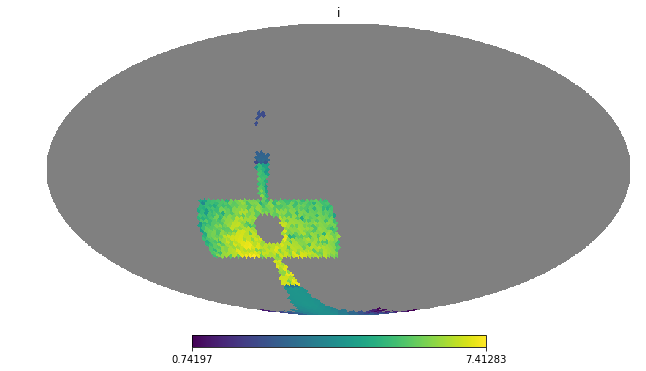

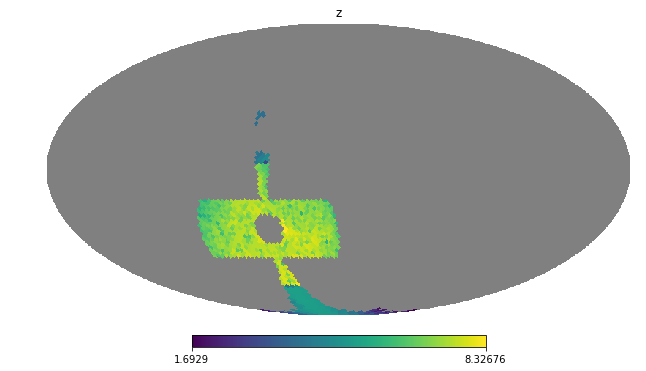

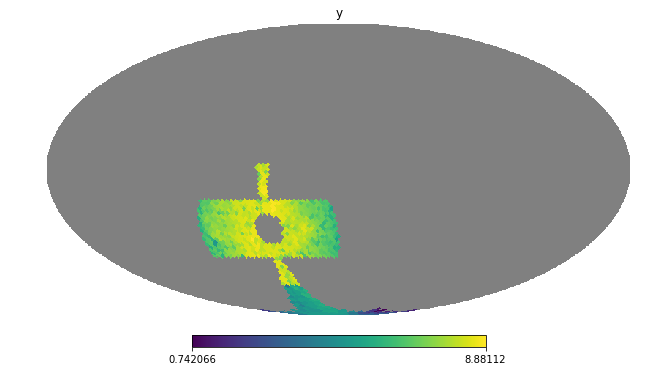

In [12]:
for survey in surveys[1:]:
    hp.mollview(survey.calc_reward_function(), title=survey.filtername)


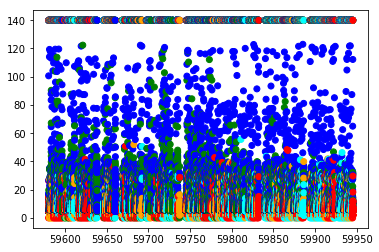

In [13]:
plt.scatter(observations['mjd'], observations['slewtime'],c=color_convert)

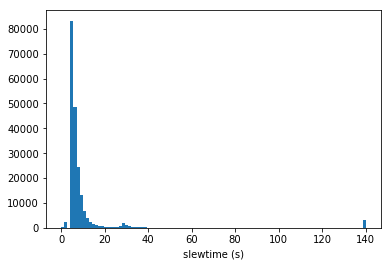

In [14]:
ack = plt.hist(observations['slewtime'], bins=100)
plt.xlabel('slewtime (s)')

In [15]:
np.where((observations['sunAlt'] > -18.) &(observations['filter'] == 'r'))


(array([ 14144,  14145,  92304,  92305, 176649, 176650]),)

In [16]:
observations['note'][-1]

''

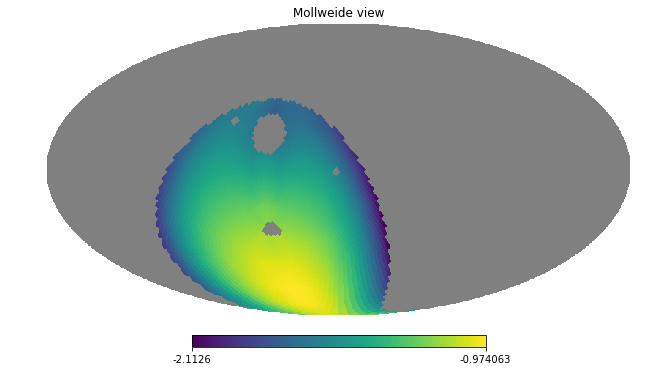

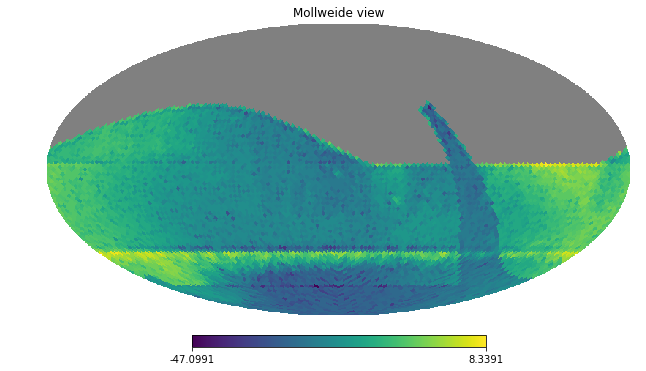

In [17]:
for bf in scheduler.surveys[0].basis_functions:
    bf_value = bf()
    if np.size(bf_value) > 1:
        hp.mollview(bf_value)

In [18]:
reward = scheduler.surveys[0].calc_reward_function()
if np.size(reward) > 1:
    hp.mollview(reward)

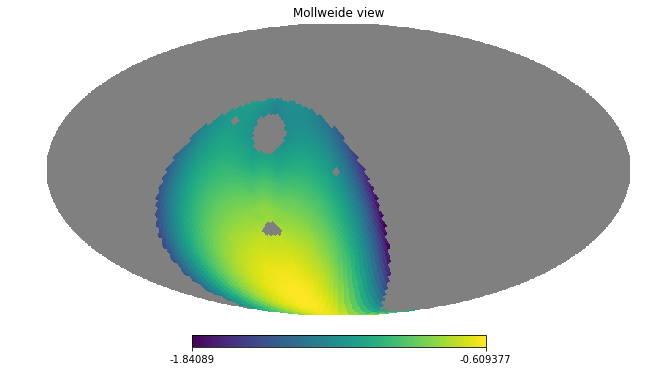

In [19]:
hp.mollview(scheduler.surveys[1].basis_functions[0]())

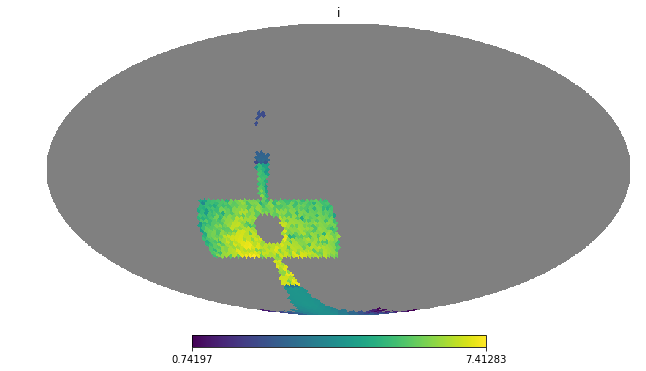

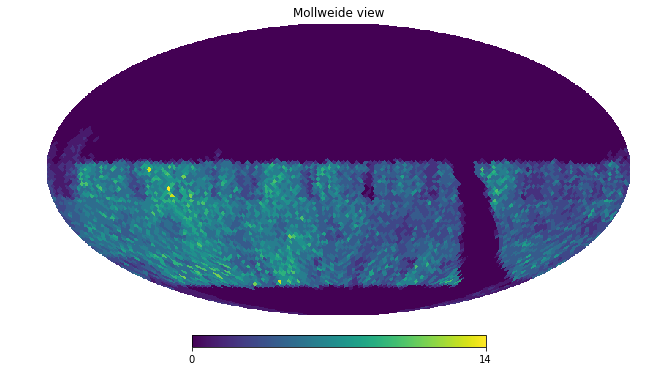

In [20]:
hp.mollview(scheduler.surveys[1].calc_reward_function(), title=scheduler.surveys[1].filtername)
hp.mollview(scheduler.surveys[1].basis_functions[1].survey_features['N_obs'].feature)

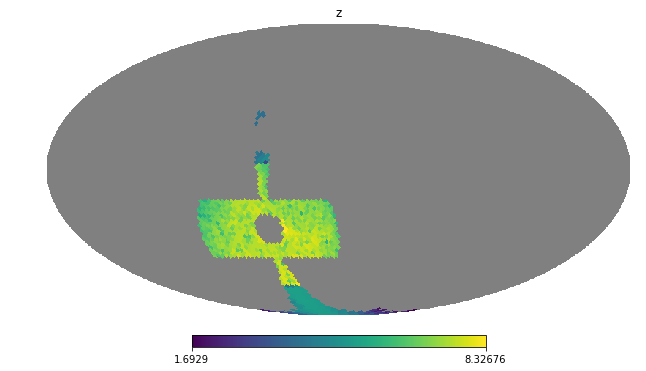

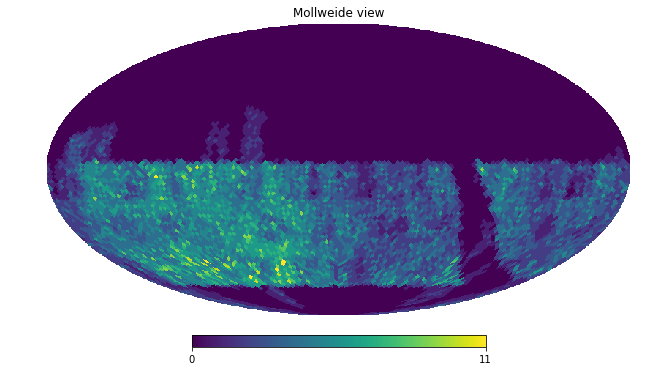

In [21]:
hp.mollview(scheduler.surveys[2].calc_reward_function(), title=scheduler.surveys[2].filtername)
hp.mollview(scheduler.surveys[2].basis_functions[1].survey_features['N_obs'].feature)

In [22]:
np.unique(observations['note'])

array(['', 'block, a, 0, 0', 'block, a, 0, 1', ..., 'block, b, 99, 7',
       'block, b, 99, 8', 'block, b, 99, 9'],
      dtype='<U40')

In [23]:
block_num = '9, 14'
o1 = np.where(observations['note'] == 'block, a, '+block_num)
o2 = np.where(observations['note'] == 'block, b, '+block_num)

In [24]:
(observations[o2]['mjd']-observations[o1]['mjd'])*24.*60.

array([ 27.05354589])

In [25]:
np.size(np.unique(observations['note']))/np.size(observations)

0.8679119777214084

In [26]:
np.size(observations)

201449

In [27]:
block = []
num = []
ab = []
for observation in observations:
    if observation['note'] == '':
        block.append(-1)
        num.append(-1)
        ab.append('')
    else:
        ack = observation['note'].split(', ')
        ab.append(ack[1])
        block.append(int(ack[2]))
        num.append(int(ack[3]))
ab = np.array(ab)
blocks = np.array(block)
num = np.array(num)

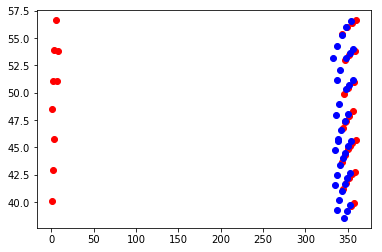

In [28]:
block = 2
good = np.where((blocks == block) & (ab == 'a'))
plt.plot(observations['az'][good], observations['alt'][good], 'ro')
good = np.where((blocks == block) & (ab == 'b'))
plt.plot(observations['az'][good], observations['alt'][good], 'bo')


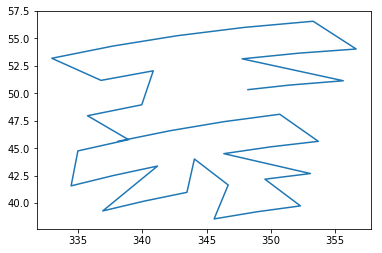

In [29]:
plt.plot(observations['az'][good], observations['alt'][good])

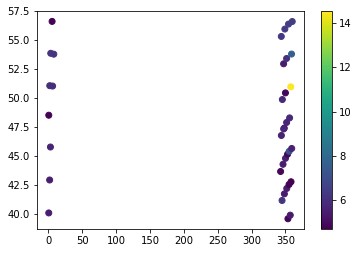

In [30]:
good = np.where((blocks == block) & (ab == 'a'))
plt.scatter(observations['az'][good], observations['alt'][good], c=observations['slewtime'][good])
cb = plt.colorbar()

In [31]:
good = np.where(blocks ==0)
observations['filter'][good]

array(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
      dtype='<U1')

In [32]:

good = np.where(blocks == 1)
observations['filter'][good]

array(['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r'],
      dtype='<U1')

In [33]:
good = np.where(blocks == 2)
observations['filter'][good]

array(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
      dtype='<U1')

In [34]:
good = np.where(blocks == 3)
observations['filter'][good]


array(['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r'],
      dtype='<U1')

In [35]:
good = np.where(blocks == 4)
observations['filter'][good]


array(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
      dtype='<U1')

In [36]:
good = np.where(blocks == 5)
observations['filter'][good]


array(['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r'],
      dtype='<U1')

In [37]:
np.mean(observations['slewtime']), np.median(observations['slewtime'])

(9.8791096286821158, 5.8827717436542786)

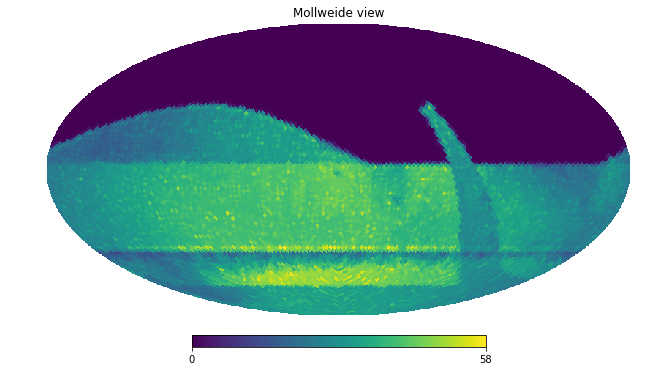

In [38]:
#what does the r-band observation map look like?
hp.mollview(surveys[0].basis_functions[1].survey_features['N_obs'].feature)
# Can probably smooth that out with better/more possible survey regions.